In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("../data/processed/accidents.csv")

df.head()


,row_id,id,source,severity,start_time,end_time,start_lat,start_lng,end_lat,end_lng,...,stop,traffic_calming,traffic_signal,turning_loop,sunrise_sunset,civil_twilight,nautical_twilight,astronomical_twilight,min_temperature_f,max_temperature_f
0,0.0,3650461,source1,2,2023-03-31 17:09:16,2023-03-31 18:09:49.000000000,45.676472,-94.174568,45.666976,-94.176184,...,0,0,0,0,day,day,day,day,31.0,35.0
1,1.0,3650462,source1,2,2023-02-27 20:55:00,2023-02-27 23:36:34.000000000,41.391812,-75.467365,41.398370,-75.484203,...,0,0,0,0,night,night,night,night,30.0,34.0
2,2.0,3650463,source1,2,2023-02-26 09:31:45,2023-02-26 11:58:19.000000000,40.850278,-73.946140,40.846945,-73.933651,...,0,0,0,0,day,day,day,day,29.0,33.0
3,3.0,3650464,source1,2,2023-03-21 17:46:42,2023-03-21 18:31:50.000000000,33.714992,-84.300188,33.714532,-84.266758,...,0,0,0,0,day,day,day,day,59.0,63.0
4,4.0,3650465,source1,2,2023-03-24 04:46:30,2023-03-24 09:22:00.000000000,33.927671,-118.266385,33.929608,-118.343065,...,0,0,0,0,night,night,night,night,55.0,59.0


## Create helper features

In [10]:
df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
df["end_time"]   = pd.to_datetime(df["end_time"], errors="coerce")

df["year"] = df["start_time"].dt.year
df["month"] = df["start_time"].dt.month
df["dayofweek"] = df["start_time"].dt.dayofweek
df["hour"] = df["start_time"].dt.hour
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["date"] = df["start_time"].dt.date

df["is_severe"] = (df["severity"] >= 3).astype(int)

df["duration_min"] = (
    df["end_time"] - df["start_time"]
).dt.total_seconds() / 60

df["duration_min"] = df["duration_min"].clip(lower=0, upper=60 * 6)


## High-level severity distribution

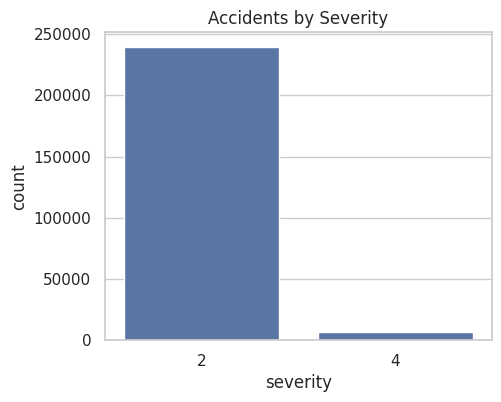

severity
2    0.97137
4    0.02863
Name: proportion, dtype: float64

In [11]:
plt.figure(figsize=(5,4))
sns.countplot(x="severity", data=df, order=sorted(df["severity"].unique()))
plt.title("Accidents by Severity")
plt.show()

df["severity"].value_counts(normalize=True).sort_index()


## Accidents trend

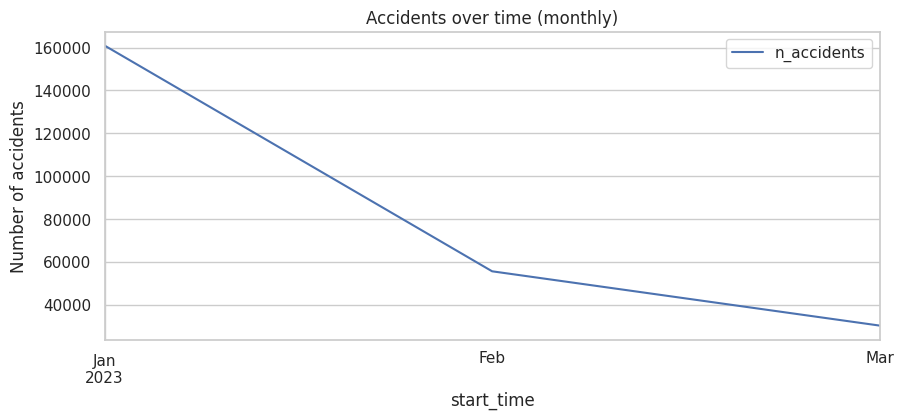

In [13]:
acc_month = (
    df.groupby(pd.Grouper(key="start_time", freq="MS"))
      .size()
      .to_frame("n_accidents")
)

acc_month.plot(y="n_accidents", figsize=(10,4))
plt.ylabel("Number of accidents")
plt.title("Accidents over time (monthly)")
plt.show()


## Severe accidents by State

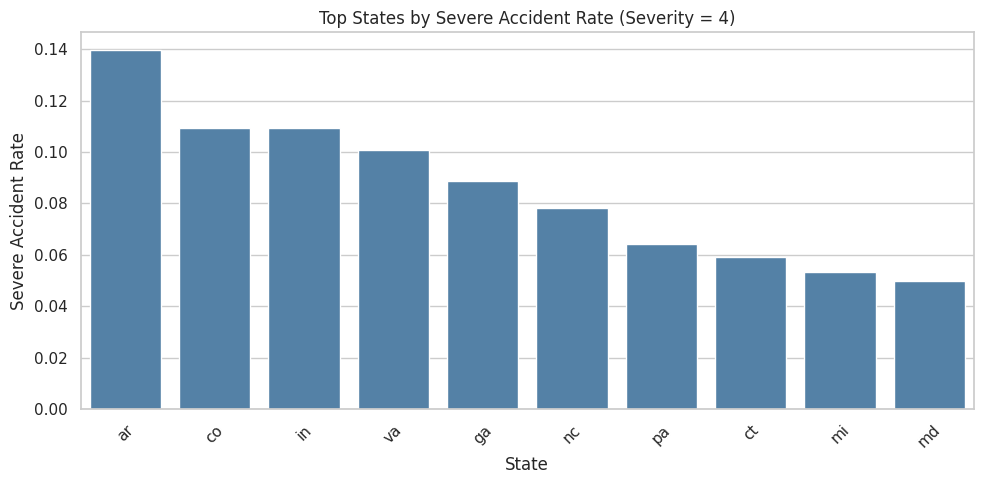

In [23]:
df["is_severe"] = (df["severity"] == 4).astype(int)

state_sev = (
    df.groupby("state")["is_severe"]
      .agg(["mean", "count"])
      .rename(columns={
          "mean": "severe_rate",
          "count": "n_accidents"
      })
      .reset_index()
)

top_severe_states = (
    state_sev_filtered
    .sort_values("severe_rate", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=top_severe_states,
    x="state",
    y="severe_rate",
    color="steelblue"
)
plt.title("Top States by Severe Accident Rate (Severity = 4)")
plt.xlabel("State")
plt.ylabel("Severe Accident Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Time-of-day and day-of-week patterns

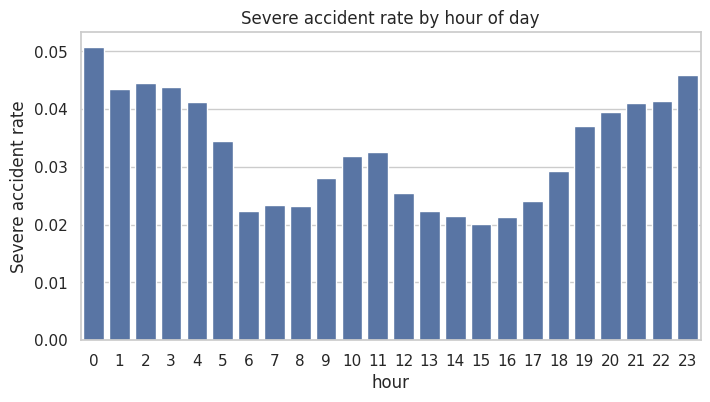

In [24]:
hour_stats = (
    df.groupby("hour")["is_severe"]
      .agg(["mean", "count"])
      .rename(columns={"mean": "severe_rate"})
)

fig, ax1 = plt.subplots(figsize=(8,4))
sns.barplot(x=hour_stats.index, y="severe_rate", data=hour_stats.reset_index(), ax=ax1)
ax1.set_ylabel("Severe accident rate")

plt.title("Severe accident rate by hour of day")
plt.show()


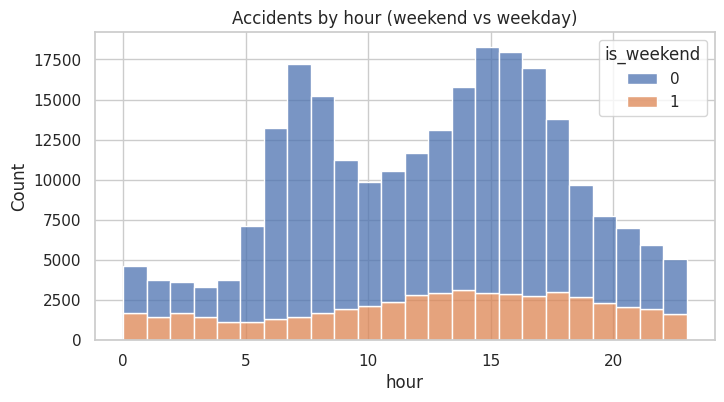

In [25]:
plt.figure(figsize=(8,4))
sns.histplot(
    data=df,
    x="hour",
    hue="is_weekend",
    multiple="stack",
    bins=24,
    stat="count"
)
plt.title("Accidents by hour (weekend vs weekday)")
plt.show()


## Weather patterns

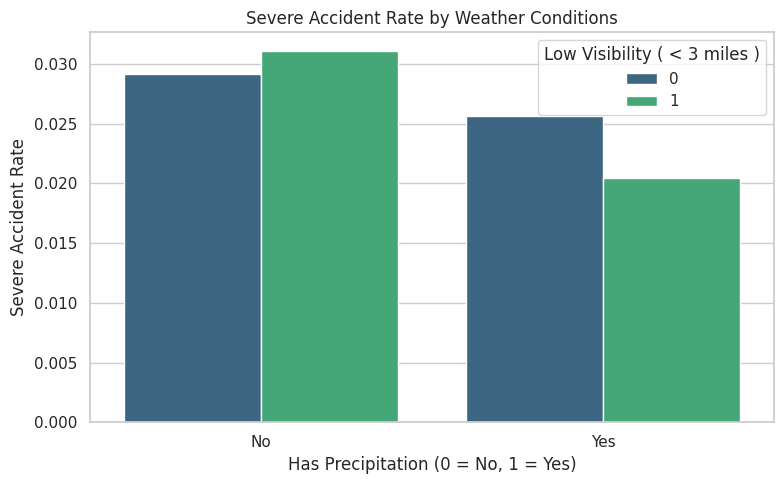

In [27]:
plt.figure(figsize=(8,5))

sns.barplot(
    data=weather_sev,
    x="has_precip",
    y="is_severe",
    hue="low_visibility",
    palette="viridis"
)

plt.title("Severe Accident Rate by Weather Conditions")
plt.xlabel("Has Precipitation (0 = No, 1 = Yes)")
plt.ylabel("Severe Accident Rate")
plt.xticks([0, 1], ["No", "Yes"])
plt.legend(title="Low Visibility ( < 3 miles )")
plt.tight_layout()
plt.show()


In [29]:
top_weather = (
    df["weather_condition"]
      .value_counts()
      .head(10)
      .index
)

wc_stats = (
    df[df["weather_condition"].isin(top_weather)]
    .groupby("weather_condition")["is_severe"]
    .mean()
    .sort_values(ascending=False)
)

wc_stats


weather_condition
fog              0.037044
cloudy           0.034376
light_snow       0.029479
wintry_mix       0.029396
fair             0.027545
partly_cloudy    0.026993
light_rain       0.026285
fair_/_windy     0.025768
mostly_cloudy    0.022816
rain             0.016524
Name: is_severe, dtype: float64

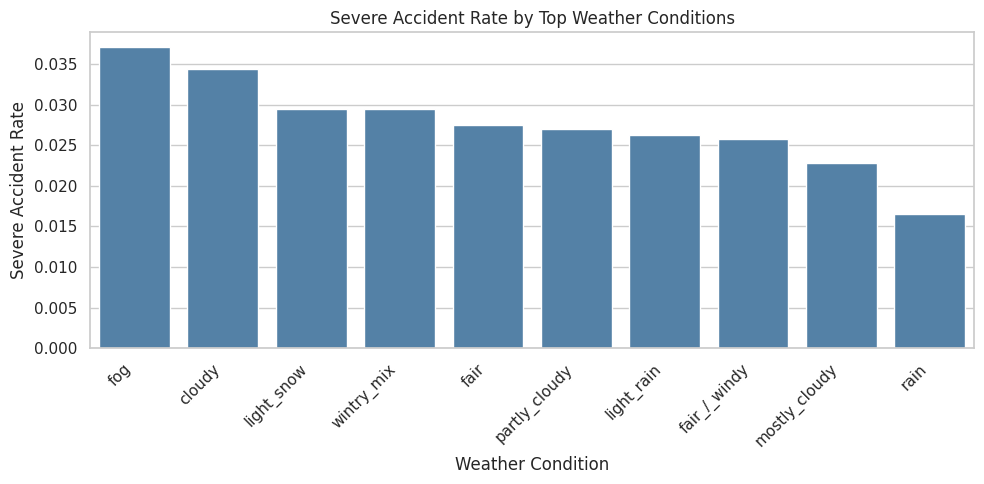

In [30]:
plt.figure(figsize=(10,5))

sns.barplot(
    x=wc_stats.index,
    y=wc_stats.values,
    color="steelblue"   # single color → no palette warning
)

plt.title("Severe Accident Rate by Top Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Severe Accident Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Distribution of accident duration

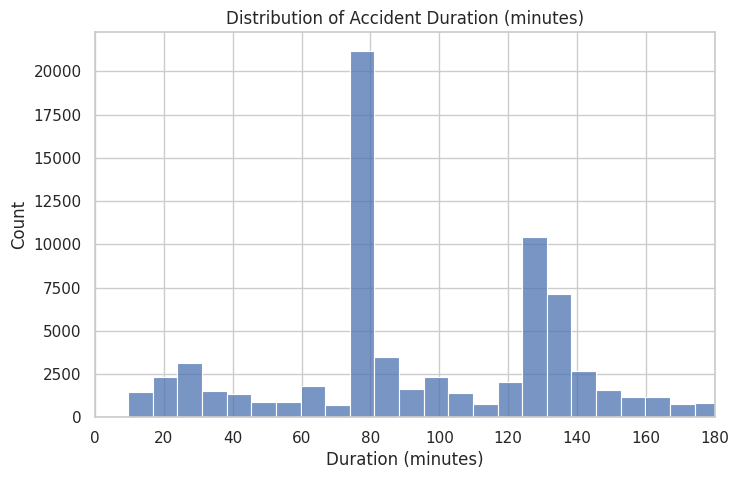

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(df["duration_min"], bins=50)
plt.xlim(0, 180)  # Show the meaningful 0–3 hours window
plt.title("Distribution of Accident Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.show()


## Duration vs severity

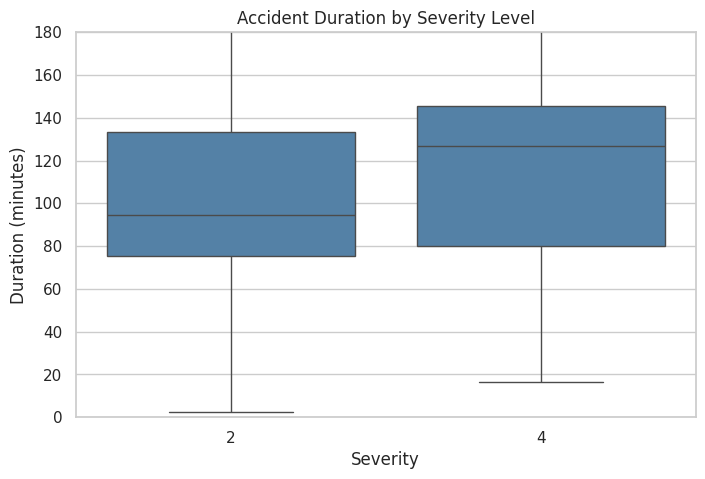

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x="severity",
    y="duration_min",
    color="steelblue" 
)
plt.ylim(0, 180)
plt.title("Accident Duration by Severity Level")

plt.xlabel("Severity")
plt.ylabel("Duration (minutes)")
plt.show()


## Duration by Weather Condition (top 10)

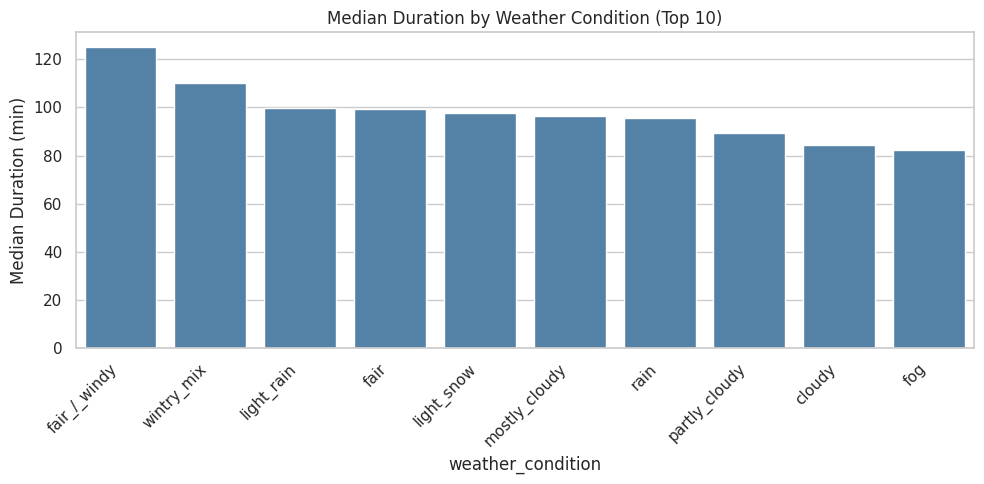

In [36]:
top_wx = df["weather_condition"].value_counts().head(10).index

wx_dur = (
    df[df["weather_condition"].isin(top_wx)]
    .groupby("weather_condition")["duration_min"]
    .median()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=wx_dur.index,
    y=wx_dur.values,
    color="steelblue"    # single color → no palette warning
)
plt.xticks(rotation=45, ha="right")
plt.title("Median Duration by Weather Condition (Top 10)")
plt.ylabel("Median Duration (min)")
plt.tight_layout()
plt.show()


## Duration by Hour of Day

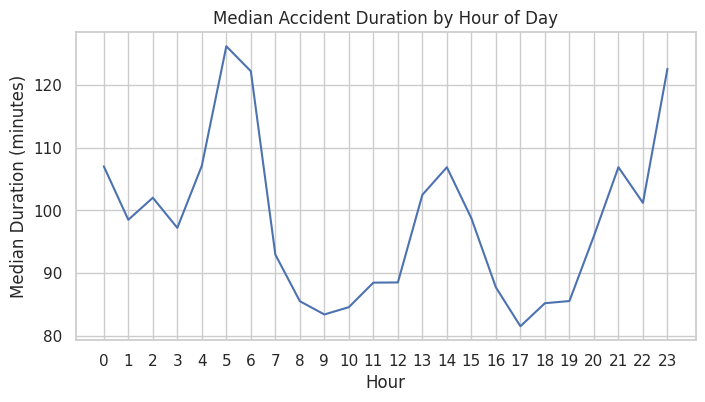

In [37]:
hour_dur = (
    df.groupby("hour")["duration_min"]
      .median()
      .reset_index()
)

plt.figure(figsize=(8,4))
sns.lineplot(data=hour_dur, x="hour", y="duration_min")
plt.title("Median Accident Duration by Hour of Day")
plt.ylabel("Median Duration (minutes)")
plt.xlabel("Hour")
plt.xticks(range(0,24))
plt.show()


## Duration vs Visibility

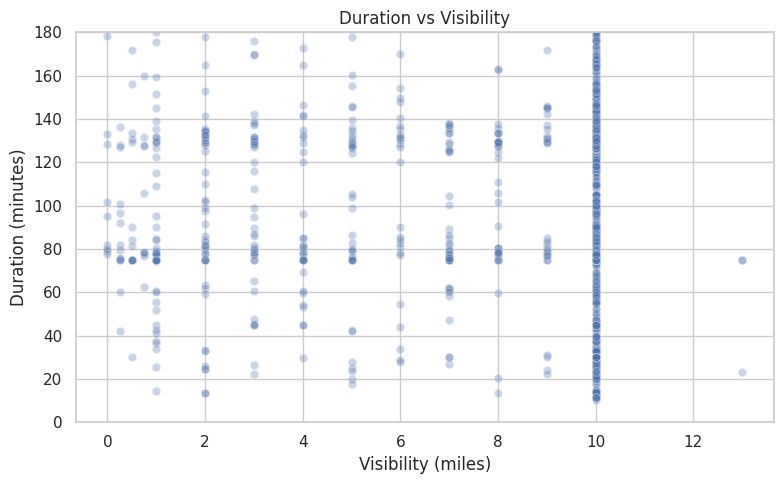

In [39]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df.sample(5000, random_state=42),  # sample for speed
    x="visibilitymi",
    y="duration_min",
    alpha=0.3
)
plt.ylim(0, 180)
plt.title("Duration vs Visibility")
plt.xlabel("Visibility (miles)")
plt.ylabel("Duration (minutes)")
plt.tight_layout()
plt.show()


## Hotspot Risk Scoring

In [42]:
df["hour"] = df["start_time"].dt.hour
df["is_severe"] = (df["severity"] >= 3).astype(int)

risk = (
    df.groupby(["state", "city", "hour"])
    .agg(
        n_accidents=("id", "count"),
        severe_rate=("is_severe", "mean"),
        median_duration=("duration_min", "median")
    )
    .reset_index()
)

risk["risk_score"] = (
    0.5 * risk["severe_rate"] +
    0.5 * (risk["median_duration"] / risk["median_duration"].max())
)

risk = risk[risk["n_accidents"] >= 20]


**Below are the top 20 location–hour combinations with the highest combined risk (severity + disruption). These are prime candidates for targeted enforcement, messaging, or infrastructure improvements.**

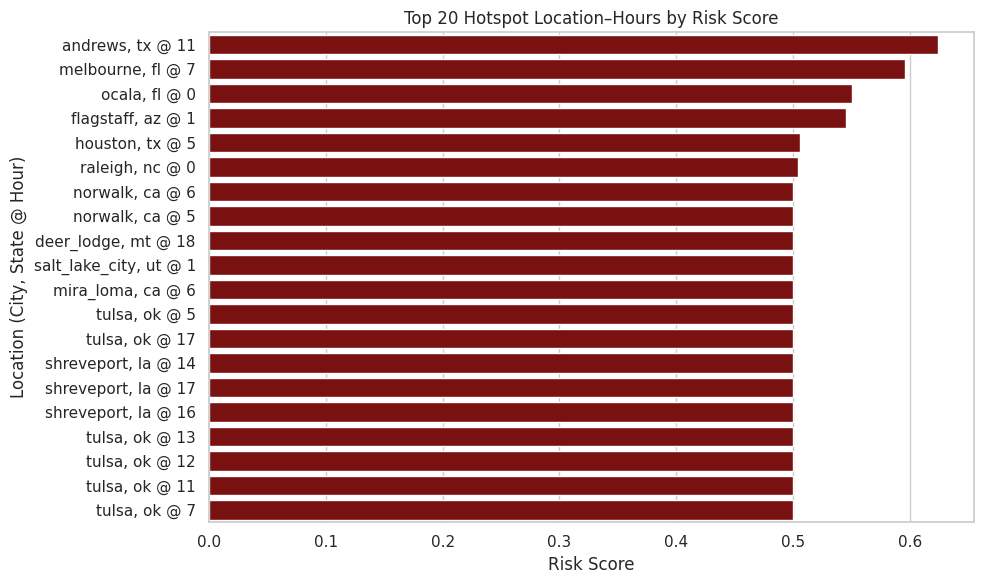

In [43]:
top_hotspots = (
    risk.sort_values("risk_score", ascending=False)
        .head(20)
)

plt.figure(figsize=(10,6))

sns.barplot(
    data=top_hotspots,
    y=top_hotspots["city"] + ", " + top_hotspots["state"] + " @ " + top_hotspots["hour"].astype(str),
    x="risk_score",
    color="darkred"   # single color → avoids palette warning
)

plt.title("Top 20 Hotspot Location–Hours by Risk Score")
plt.xlabel("Risk Score")
plt.ylabel("Location (City, State @ Hour)")
plt.tight_layout()
plt.show()


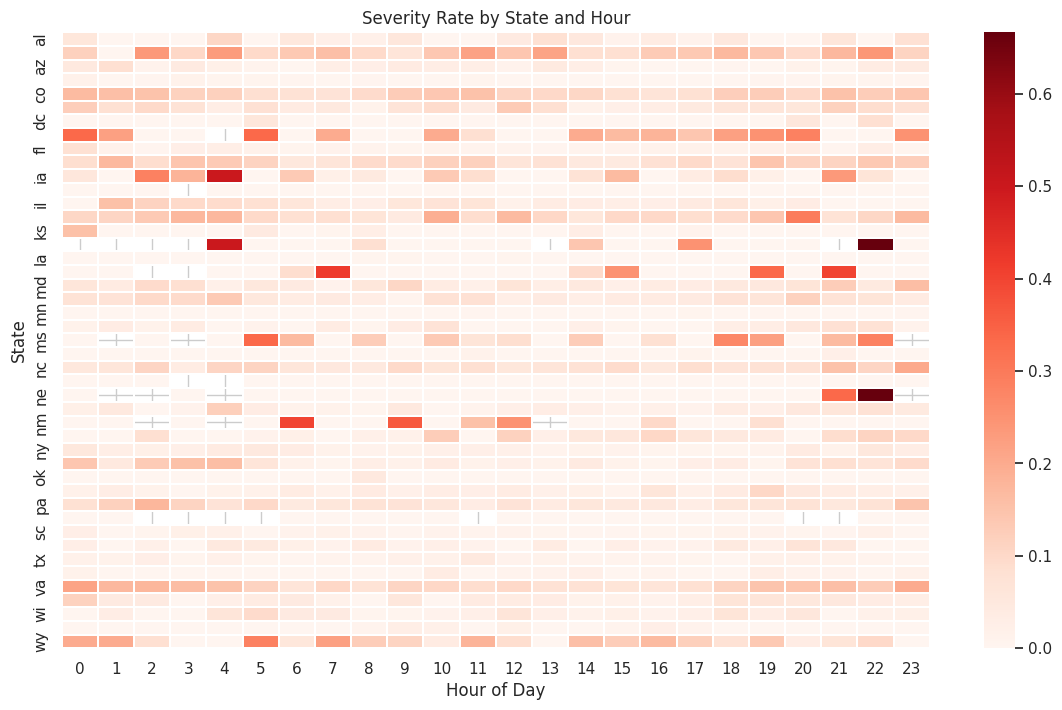

In [45]:
state_hour = (
    df.groupby(["state", "hour"])["is_severe"]
      .mean()
      .reset_index()
      .pivot(index="state", columns="hour", values="is_severe")
)

plt.figure(figsize=(14,8))
sns.heatmap(state_hour, cmap="Reds", linewidths=0.3)
plt.title("Severity Rate by State and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("State")
plt.show()


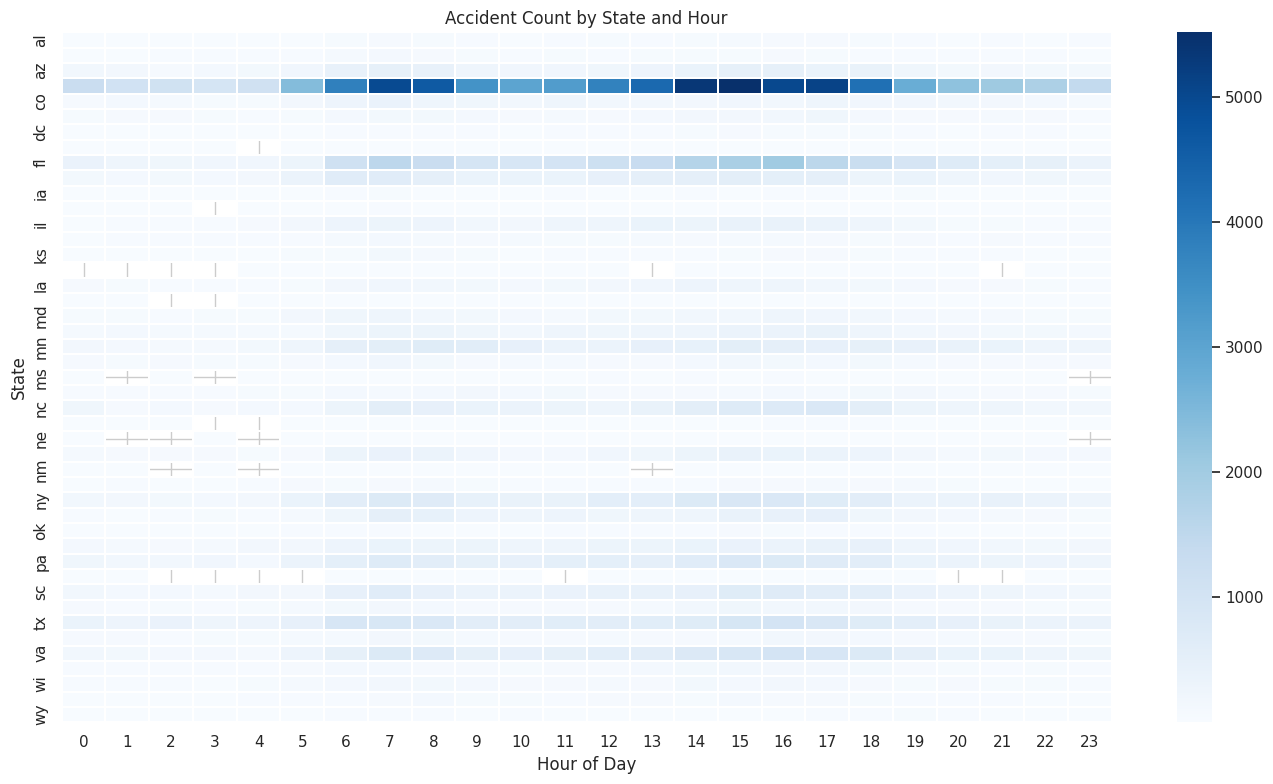

In [49]:
state_hour_counts = (
    df.groupby(["state", "hour"])["id"]
      .count()
      .reset_index()
      .pivot(index="state", columns="hour", values="id")
)

plt.figure(figsize=(14,8))
sns.heatmap(state_hour_counts, cmap="Blues", linewidths=0.3)
plt.title("Accident Count by State and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("State")
plt.tight_layout()
plt.show()


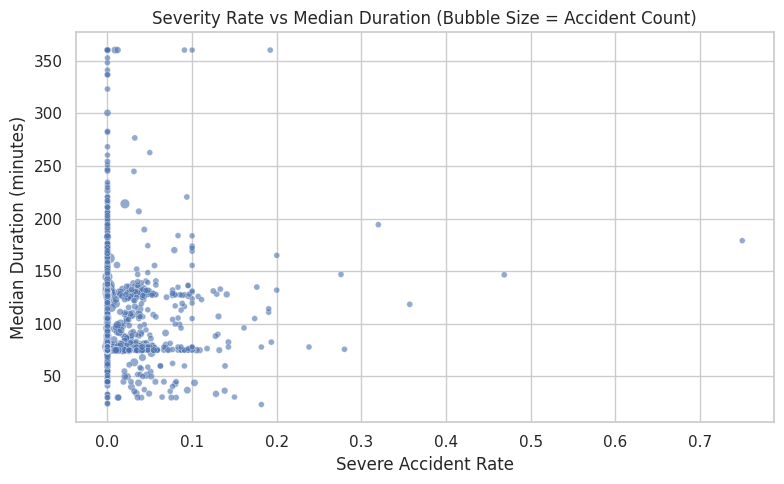

In [50]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=risk,
    x="severe_rate",
    y="median_duration",
    size="n_accidents",
    alpha=0.6,
    legend=False   # avoids clutter when size is used
)
plt.title("Severity Rate vs Median Duration (Bubble Size = Accident Count)")
plt.xlabel("Severe Accident Rate")
plt.ylabel("Median Duration (minutes)")
plt.tight_layout()
plt.show()
